<a href="https://www.kaggle.com/code/avtnshm/inx-future-inc-kpis-random-forest?scriptVersionId=146542637" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#####  Mr Brain, CEO of the INX Future Inc data analytics and automation solutions provider wants us to create an interactive dashboard to analyse the employee performance indexes and track the core underlying causes of their performance issues (clear indicators of non-performing employees).

### Questions (KPIs)
 - Does educational level responsible for the attrition of employees?
- Which age group of employees has the maximum attrition?
- Are the employees unsatisfied with the specific job role?
- Which top 5 job role indicates the maximum attrition of employees?
- Does a highly experienced person responsible for leaving the company?
- How does the % salary hike play a crucial role in the increase in attrition of the employee?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
!pip install xlrd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 3.1 MB/s eta 0:00:00


In [2]:
df= pd.read_excel("/kaggle/input/employee-performance-analysis-inx-future-inc/INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.xls")
df.head()

,EmpNumber,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,...,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
0,E1001000,32,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,10,3,...,4,10,2,2,10,7,0,8,No,3
1,E1001006,47,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,14,4,...,4,20,2,3,7,7,1,7,No,3
2,E1001007,40,Male,Life Sciences,Married,Sales,Sales Executive,Travel_Frequently,5,4,...,3,20,2,3,18,13,1,12,No,4
3,E1001009,41,Male,Human Resources,Divorced,Human Resources,Manager,Travel_Rarely,10,4,...,2,23,2,2,21,6,12,6,No,3
4,E1001010,60,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,16,4,...,4,10,1,3,2,2,2,2,No,3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   EmpNumber                     1200 non-null   object
 1   Age                           1200 non-null   int64 
 2   Gender                        1200 non-null   object
 3   EducationBackground           1200 non-null   object
 4   MaritalStatus                 1200 non-null   object
 5   EmpDepartment                 1200 non-null   object
 6   EmpJobRole                    1200 non-null   object
 7   BusinessTravelFrequency       1200 non-null   object
 8   DistanceFromHome              1200 non-null   int64 
 9   EmpEducationLevel             1200 non-null   int64 
 10  EmpEnvironmentSatisfaction    1200 non-null   int64 
 11  EmpHourlyRate                 1200 non-null   int64 
 12  EmpJobInvolvement             1200 non-null   int64 
 13  EmpJobLevel       

### Education level vs Attrition

<Axes: xlabel='EmpEducationLevel'>

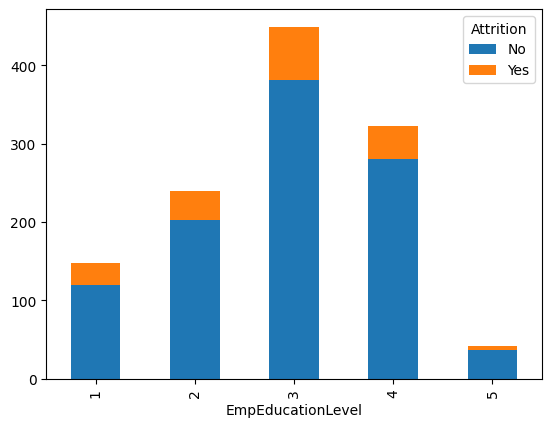

In [4]:
df.groupby('EmpEducationLevel')['Attrition'].value_counts().unstack().plot(kind='bar', stacked=True)

### Age Group vs attrition

In [5]:
df['AgeGroup'] = pd.cut(df['Age'], [18, 25, 35, 45, 55, 65], labels=['18-24', '25-34', '35-44', '45-54', '55-64'])
max_attrition_age_group = df.loc[df['Attrition'] == 'Yes', 'AgeGroup'].value_counts().idxmax()
max_attrition_age_group

'25-34'

### Job role  vs Satisfaction

<Axes: xlabel='EmpJobRole'>

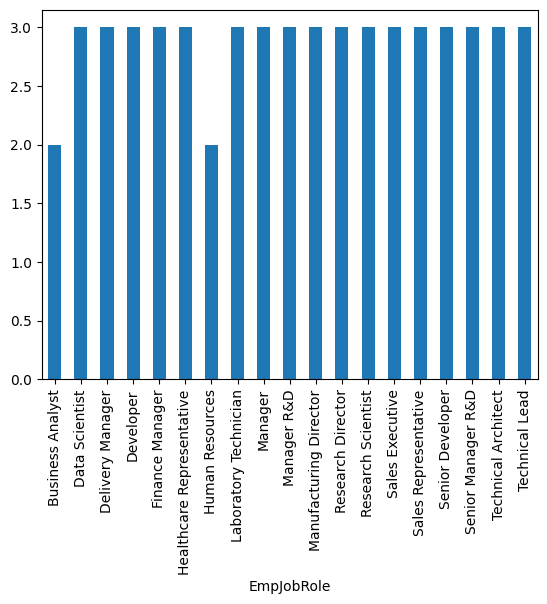

In [6]:
df.groupby('EmpJobRole')['EmpJobSatisfaction'].median().plot(kind='bar')

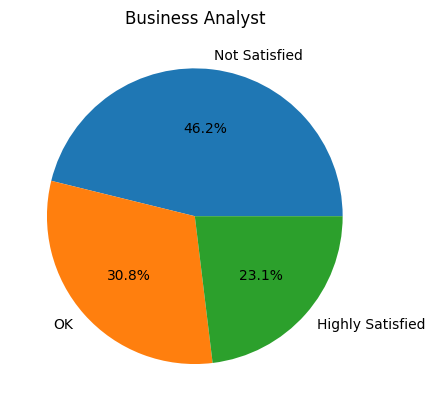

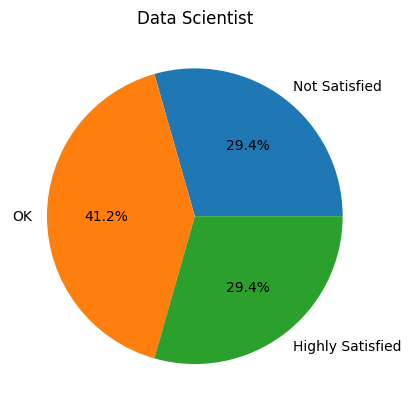

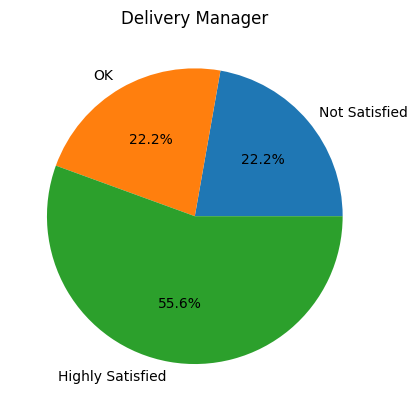

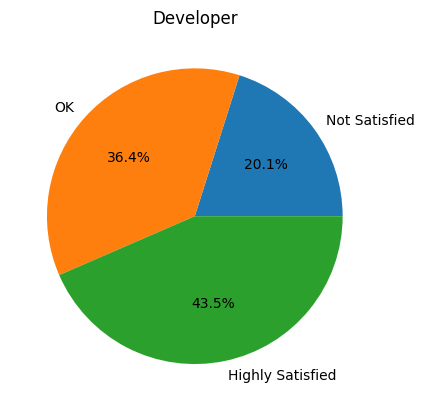

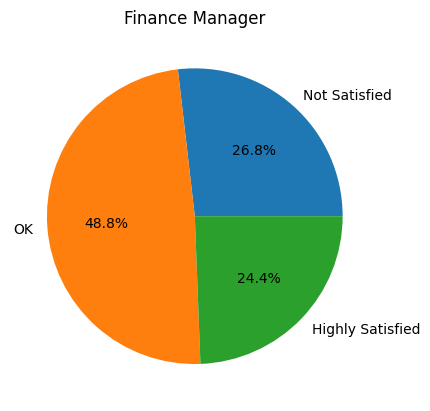

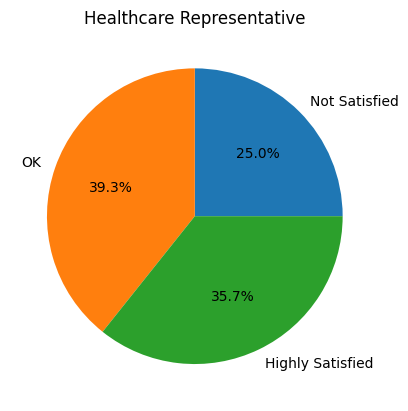

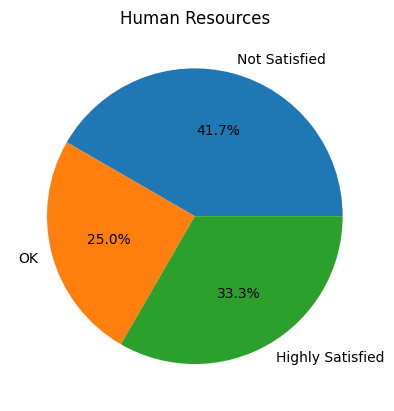

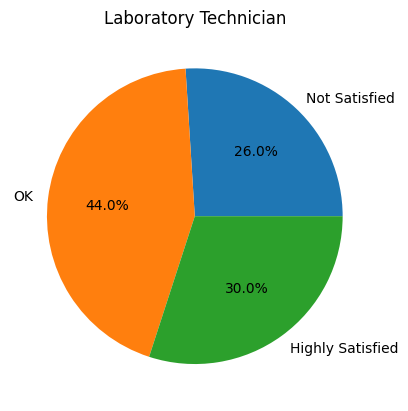

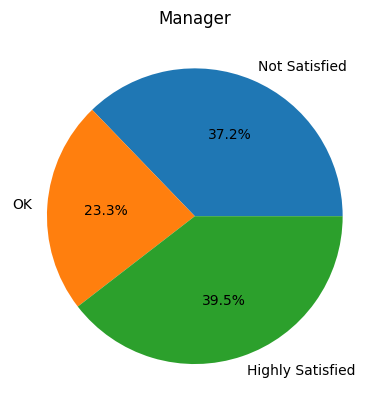

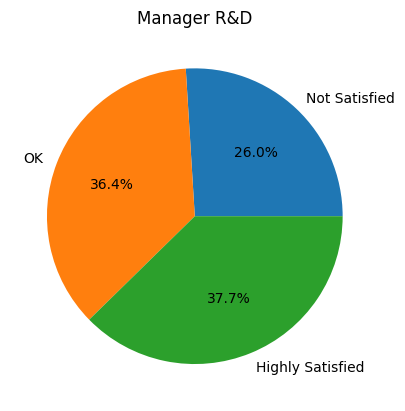

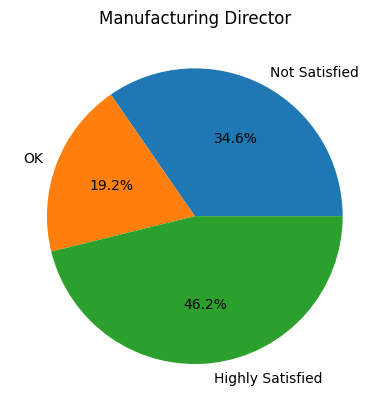

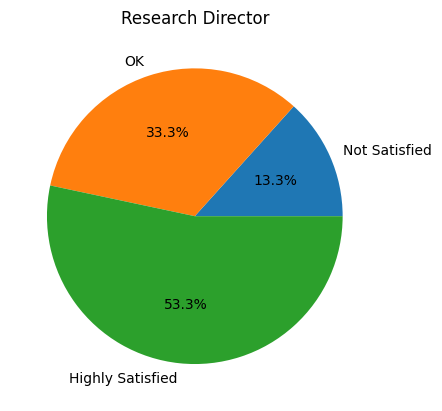

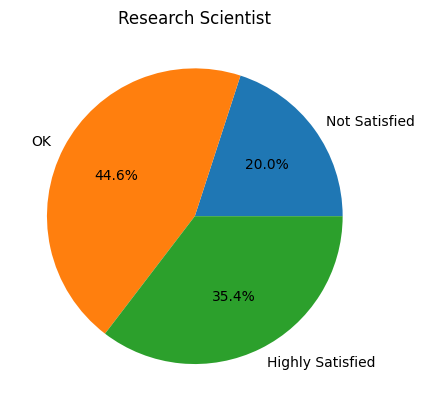

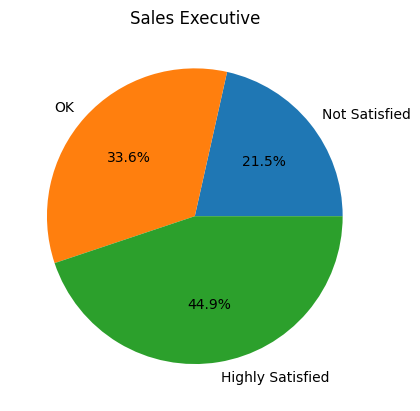

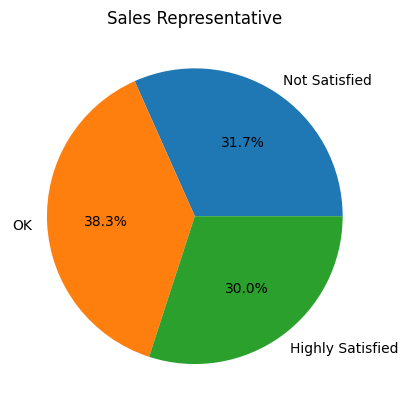

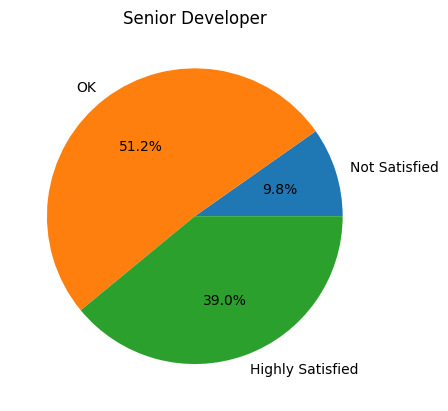

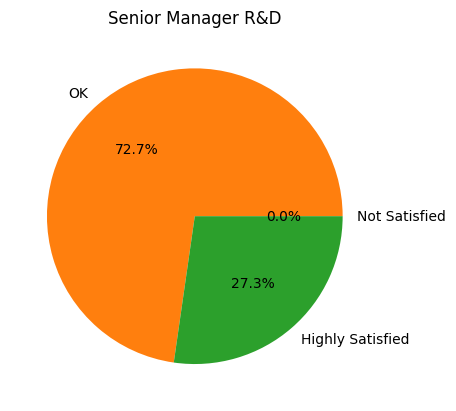

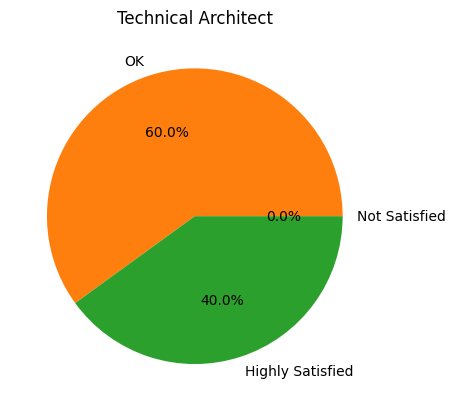

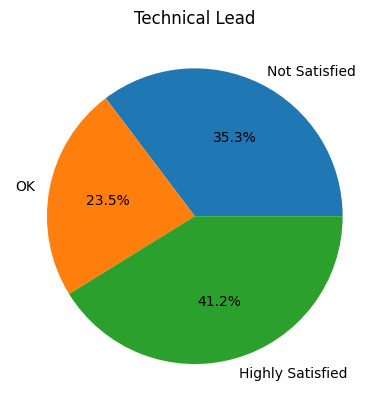

In [7]:
df['SatisfactionCategory'] = pd.cut(df['EmpJobSatisfaction'], bins=[1, 2, 3, 4], labels=['Not Satisfied', 'OK', 'Highly Satisfied'])
job_role_satisfaction = df.groupby('EmpJobRole')['SatisfactionCategory'].value_counts().unstack(fill_value=0)
# Create a pie chart for each job role
for job_role in job_role_satisfaction.index:
    plt.figure()
    plt.pie(job_role_satisfaction.loc[job_role], labels=job_role_satisfaction.columns, autopct='%1.1f%%')
    plt.title(job_role)
    plt.show()

<Axes: xlabel='EmpJobRole'>

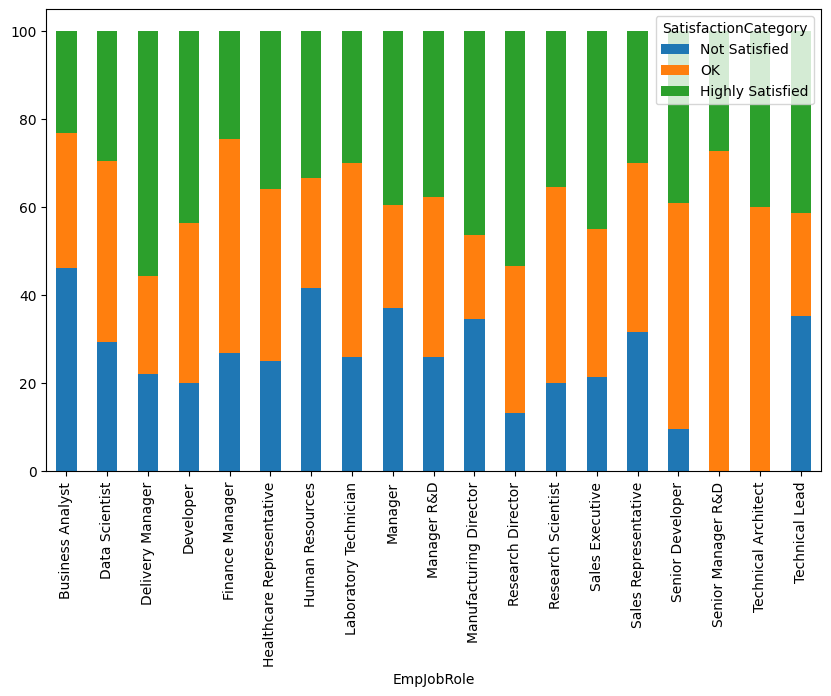

In [8]:
satisfaction = df.groupby(['EmpJobRole', 'SatisfactionCategory'])['SatisfactionCategory'].count().unstack(fill_value=0)
satisfaction.div(satisfaction.sum(axis=1), axis=0).mul(100).plot(kind='bar', stacked=True, figsize=(10, 6))

### Job role vs attirition

In [9]:
top_5_attrition_jobs = df.groupby('EmpJobRole')['Attrition'].count().sort_values(ascending=False).head(5)
print(top_5_attrition_jobs)

EmpJobRole
Sales Executive         270
Developer               236
Manager R&D              94
Research Scientist       77
Sales Representative     69
Name: Attrition, dtype: int64


### Experience vs attiriton

In [10]:
# Calculate the statistics
exp_statistics = df[['TotalWorkExperienceInYears', 'ExperienceYearsAtThisCompany', 'ExperienceYearsInCurrentRole']].agg(['mean', 'median', 'max'])
exp_statistics

,TotalWorkExperienceInYears,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole
mean,11.33,7.0775,4.291667
median,10.00,5.0000,3.000000
max,40.00,40.0000,18.000000


In [11]:
# Calculate the average experience for employees who left
avg_experience_left = df[df['Attrition'] == 'Yes'][['TotalWorkExperienceInYears', 'ExperienceYearsAtThisCompany', 'ExperienceYearsInCurrentRole']].mean()

# Calculate the average experience for employees who didn't leave
avg_experience_not_left = df[df['Attrition'] == 'No'][['TotalWorkExperienceInYears', 'ExperienceYearsAtThisCompany', 'ExperienceYearsInCurrentRole']].mean()

# Check if highly experienced people (e.g., average experience > threshold) are responsible for leaving
threshold = 7 # As the mean of ExperienceYearsAtThisCompany is 7
highly_experienced_leaving = avg_experience_left.mean() > threshold

highly_experienced_leaving


False

#### So we can conclude that experienced and highly experince people are NOT responsible for attirition

 ### Salary Hike vs Attrition

In [12]:
bins = range(0, 26, 5)
df['SalaryHikeInterval'] = pd.cut(df['EmpLastSalaryHikePercent'], bins)
attrition_by_hike_interval = df.groupby('SalaryHikeInterval')['Attrition'].value_counts().unstack(fill_value=0)
attrition_by_hike_interval

Attrition,No,Yes
SalaryHikeInterval,,
"(0, 5]",0,0
"(5, 10]",0,0
"(10, 15]",635,111
"(15, 20]",276,45
"(20, 25]",111,22


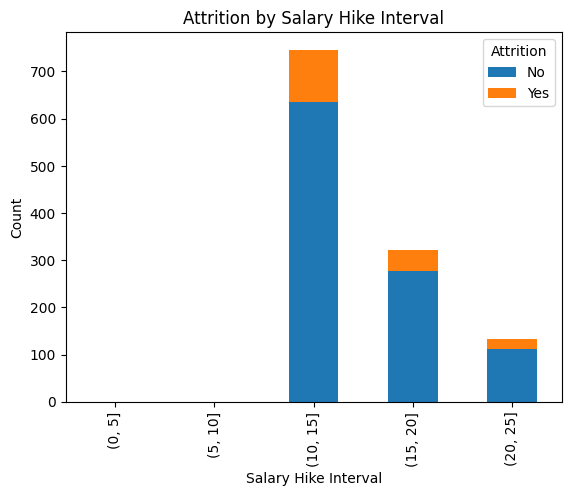

In [13]:
attrition_by_hike_interval.plot(kind='bar', stacked=True)
plt.xlabel('Salary Hike Interval')
plt.ylabel('Count')
plt.title('Attrition by Salary Hike Interval')
plt.legend(title='Attrition')
plt.show()

In [14]:
categorical_columns = df.select_dtypes(include=['object'])
categorical_columns

,EmpNumber,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,OverTime,Attrition
0,E1001000,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,No,No
1,E1001006,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,No,No
2,E1001007,Male,Life Sciences,Married,Sales,Sales Executive,Travel_Frequently,Yes,No
3,E1001009,Male,Human Resources,Divorced,Human Resources,Manager,Travel_Rarely,No,No
4,E1001010,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,No,No
...,...,...,...,...,...,...,...,...,...
1195,E100992,Female,Medical,Divorced,Sales,Sales Executive,Travel_Frequently,Yes,No
1196,E100993,Male,Life Sciences,Single,Development,Senior Developer,Travel_Rarely,No,No
1197,E100994,Male,Medical,Married,Development,Senior Developer,Travel_Rarely,Yes,No
1198,E100995,Female,Medical,Single,Data Science,Data Scientist,Travel_Rarely,No,No


In [15]:
categorical_columns = df.select_dtypes(include=['object'])
categorical_columns

,EmpNumber,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,OverTime,Attrition
0,E1001000,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,No,No
1,E1001006,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,No,No
2,E1001007,Male,Life Sciences,Married,Sales,Sales Executive,Travel_Frequently,Yes,No
3,E1001009,Male,Human Resources,Divorced,Human Resources,Manager,Travel_Rarely,No,No
4,E1001010,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,No,No
...,...,...,...,...,...,...,...,...,...
1195,E100992,Female,Medical,Divorced,Sales,Sales Executive,Travel_Frequently,Yes,No
1196,E100993,Male,Life Sciences,Single,Development,Senior Developer,Travel_Rarely,No,No
1197,E100994,Male,Medical,Married,Development,Senior Developer,Travel_Rarely,Yes,No
1198,E100995,Female,Medical,Single,Data Science,Data Scientist,Travel_Rarely,No,No


In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])


In [17]:
df

,EmpNumber,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,...,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating,AgeGroup,SatisfactionCategory,SalaryHikeInterval
0,0,32,1,2,2,5,13,2,10,3,...,2,10,7,0,8,0,3,25-34,Highly Satisfied,"(10, 15]"
1,1,47,1,2,2,5,13,2,14,4,...,3,7,7,1,7,0,3,45-54,NaN,"(10, 15]"
2,2,40,1,1,1,5,13,1,5,4,...,3,18,13,1,12,0,4,35-44,NaN,"(20, 25]"
3,3,41,1,0,0,3,8,2,10,4,...,2,21,6,12,6,0,3,35-44,Highly Satisfied,"(10, 15]"
4,4,60,1,2,2,5,13,2,16,4,...,3,2,2,2,2,0,3,55-64,NaN,"(10, 15]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1195,27,0,3,0,5,13,1,3,1,...,3,6,5,0,4,0,4,25-34,Highly Satisfied,"(15, 20]"
1196,1196,37,1,1,2,1,15,2,10,2,...,3,1,0,0,0,0,3,35-44,Highly Satisfied,"(15, 20]"
1197,1197,50,1,3,1,1,15,2,28,1,...,3,20,8,3,8,0,3,45-54,OK,"(10, 15]"
1198,1198,34,0,3,2,0,1,2,9,3,...,4,8,7,7,7,0,3,25-34,Not Satisfied,"(10, 15]"


In [18]:
df.drop(columns=['EmpNumber','AgeGroup', 'SatisfactionCategory', 'SalaryHikeInterval'], inplace=True)
df

,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,...,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
0,32,1,2,2,5,13,2,10,3,4,...,4,10,2,2,10,7,0,8,0,3
1,47,1,2,2,5,13,2,14,4,4,...,4,20,2,3,7,7,1,7,0,3
2,40,1,1,1,5,13,1,5,4,4,...,3,20,2,3,18,13,1,12,0,4
3,41,1,0,0,3,8,2,10,4,2,...,2,23,2,2,21,6,12,6,0,3
4,60,1,2,2,5,13,2,16,4,1,...,4,10,1,3,2,2,2,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,27,0,3,0,5,13,1,3,1,4,...,2,6,3,3,6,5,0,4,0,4
1196,37,1,1,2,1,15,2,10,2,4,...,1,4,2,3,1,0,0,0,0,3
1197,50,1,3,1,1,15,2,28,1,4,...,3,20,3,3,20,8,3,8,0,3
1198,34,0,3,2,0,1,2,9,3,4,...,2,9,3,4,8,7,7,7,0,3


In [19]:
X= df.drop('Attrition', axis=1)
y=df['Attrition']

In [20]:
Train = []
Test = []
CV= [] #Cross Validation


for i in range (0,10): #if random state is more than, run till 20, if less than 10, use it(keep increasing nos progressivley)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    from sklearn.linear_model import LogisticRegression
    m = LogisticRegression()
    m.fit(X_train, y_train)
    ypred_train = m.predict(X_train)
    ypred_test = m.predict(X_test)
    Train.append(m.score(X_train, y_train))
    Test.append(m.score(X_test, y_test))
    from sklearn.model_selection import cross_val_score
    CV.append(cross_val_score(m, X, y, cv= 5). mean()) #cv=5, since train test split is 80:20 or five parts
    

em= pd.DataFrame({"Train": Train, "Test":Test, "CV":CV})
gm = em[(abs(em['Train']- em['Test'])<=0.05) & (abs(em['Test']- em['CV'])<=0.05)]
print("best random_state_number:", gm[gm["Test"]==gm["Test"].max()].index.to_list()[0])

best random_state_number: 1


In [21]:
#Random Forest Classifier wiht default parameters

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=1)
model.fit(X_train,y_train)

#Prediction
ypred_train = model.predict(X_train)
ypred_test = model.predict(X_test)


#Evaluation

from sklearn.metrics import accuracy_score
print("Train Accuracy:", accuracy_score(ypred_train, y_train))
print("Test Accuracy:", accuracy_score(ypred_test, y_test))
from sklearn.model_selection import cross_val_score
print("Cross Validation Score:", cross_val_score(model,X,y, cv=5).mean())


Train Accuracy: 1.0
Test Accuracy: 0.8458333333333333
Cross Validation Score: 0.8633333333333333
